In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
from functools import reduce
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import matplotlib.patches as mpatches
import warnings
import random
warnings.filterwarnings("ignore")

In [2]:
class Data():
    def __init__(self, dfs):
        self.original_dfs = dfs
        self.dfs = dfs
        self.cleaned = False
        self.output = None
        
    def clean(self):
        if self.cleaned:
            return
        for i in range(len(self.dfs)):
            self.dfs[i] = self.dfs[i][self.dfs[i]["availability_30"] > 0]
            self.dfs[i]['occupancy_rate'] =(30 - self.dfs[i]['availability_30']) / 30
            self.dfs[i]["price"] = self.dfs[i]["price"].apply(lambda x: float(x.replace(',','')[1:]))

        merged_df = reduce(lambda left,right: pd.merge(left, right[['id', 'price', 'occupancy_rate']],on='id', how = 'inner', suffixes=('_x', '_y')), self.dfs)
        price_demand = merged_df[['id','price_x', 'price_y', 'occupancy_rate_x', 'occupancy_rate_y']]
        price_demand.columns = ['id','price_1','price_2','price_3','price_4', 'demand_1', 'demand_2', 'demand_3', 'demand_4']
        price_demand = price_demand.merge(df1[['id', 'reviews_per_month']], on='id', how = 'inner').dropna()
        price_demand['demand'] = 1/4*(price_demand['demand_1'] + price_demand['demand_2'] + price_demand['demand_3'] + price_demand['demand_4'])
        price_demand['price'] = 1/4*(price_demand['price_1'] + price_demand['price_2'] + price_demand['price_3'] + price_demand['price_4'])
        df_21 = price_demand.drop(['price_1', "price_2", "price_3", "price_4", 'demand_1', "demand_2", "demand_3", "demand_4"], axis=1).merge(df1[["id", "neighbourhood_cleansed", "bedrooms", "beds", "room_type", "minimum_nights", "amenities", "property_type", "listing_url", "host_since", "review_scores_rating", "calculated_host_listings_count", "accommodates"]], how = 'inner', on=['id'])
        df_21 = df_21[df_21['minimum_nights'] <= 100]
        df_21 = df_21[df_21['demand'] > 0]
        self.output = df_21
        self.dfs = self.original_dfs
        
        
    def add(self, name, func):
        self.output[name] = func(self.output)
        return
    
    def get(self):
        return self.output
    
    def original(self):
        return self.original_dfs
    
    def dropna(self, columns):
        self.output = self.output.dropna(subset=columns)
        return

In [3]:
df1 = pd.read_csv('Data/listings3.csv')
df2 = pd.read_csv('Data/listings6.csv')
df3 = pd.read_csv('Data/listings9.csv')
df4 = pd.read_csv('Data/listings12.csv')
dfs = [df1, df2, df3, df4]


In [4]:
data = Data(dfs)

In [5]:
data.clean()
data.add("price_per_person", lambda x: x['price']/x['accommodates'])
data.dropna(['room_type', "price_per_person", "review_scores_rating", "accommodates", "room_type"])

In [6]:
df = data.get()

In [7]:
df['log_demand'] = np.log((df['demand'])/(1-df['demand']))

<AxesSubplot:>

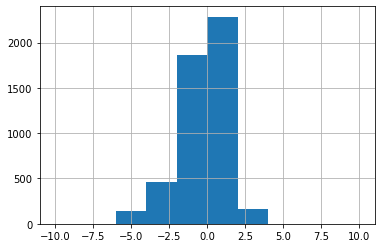

In [8]:
df.replace([np.inf, -np.inf], -50, inplace=True)
df['log_demand'].hist(range=(-10,10))

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

In [10]:
df = data.get()

In [11]:
df = df.dropna()

In [12]:
df.columns

Index(['id', 'reviews_per_month', 'demand', 'price', 'neighbourhood_cleansed',
       'bedrooms', 'beds', 'room_type', 'minimum_nights', 'amenities',
       'property_type', 'listing_url', 'host_since', 'review_scores_rating',
       'calculated_host_listings_count', 'accommodates', 'price_per_person',
       'log_demand'],
      dtype='object')

Zillow Housing data

In [13]:
import geopy

In [14]:
neighborhood_location = df1.groupby('neighbourhood_cleansed').mean()[['longitude', 'latitude']]

In [15]:
neighborhood_location = np.round(neighborhood_location[['longitude','latitude']], 5)

In [16]:
def get_zipcode(df, geolocator, lat_field, lon_field):
    location = geolocator.reverse((df[lat_field], df[lon_field]))
    if 'postcode' in location.raw['address'].keys():
        return location.raw['address']['postcode']
    else:
        return 0


geolocator = geopy.Nominatim(user_agent='Jiayang_Nie')

zipcodes = neighborhood_location.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='latitude', lon_field='longitude')

In [17]:
zipcodes['Agua Dulce'] = '91390'
zipcodes['Angeles Crest'] = '91011'
zipcodes['Ridge Route'] = '93225'
zipcodes['Tujunga Canyons'] = '91042'
zipcodes['Unincorporated Catalina Island'] = '90704'
zipcodes['Unincorporated Santa Susana Mountains'] = '93063'
zipcodes['Leona Valley'] = '93551'

In [18]:
zipcodes = zipcodes.apply(lambda x: x[0:5]).astype(int)

In [19]:
zipcodes = zipcodes.to_frame().reset_index()
zipcodes.columns = ['neighbourhood_cleansed', 'zipcode']

In [20]:
zipcodes

,neighbourhood_cleansed,zipcode
0,Acton,93510
1,Adams-Normandie,90007
2,Agoura Hills,91301
3,Agua Dulce,91390
4,Alhambra,91801
...,...,...
258,Willowbrook,90059
259,Wilmington,90744
260,Windsor Square,90004
261,Winnetka,91306


In [21]:
df = pd.merge(df, zipcodes, on = 'neighbourhood_cleansed')

In [23]:
one_bed = pd.read_csv(r"Data\zillow_1bed.csv")
two_bed = pd.read_csv(r"Data\zillow_2bed.csv")
three_bed = pd.read_csv(r"Data\zillow_3bed.csv")
four_bed = pd.read_csv(r"Data\zillow_4bed.csv")
five_bed = pd.read_csv(r"Data\zillow_5bed.csv")

In [26]:
def look_for(row):
    nbeds = row['bedrooms']
    zipcode = row['zipcode']
    if nbeds == 1:
        toReturn = one_bed[one_bed['RegionID'] == zipcode]['2021-12-31']
    elif nbeds == 2:
        toReturn = two_bed[two_bed['RegionID'] == zipcode]['2021-12-31']
    elif nbeds == 3:
        toReturn = three_bed[three_bed['RegionID'] == zipcode]['2021-12-31']
    elif nbeds == 4:
        toReturn = four_bed[four_bed['RegionID'] == zipcode]['2021-12-31']
    else:
        toReturn = five_bed[five_bed['RegionID'] == zipcode]['2021-12-31']
    while toReturn.empty:
        zipcode += 1
        if nbeds == 1:
            toReturn = one_bed[one_bed['RegionID'] == zipcode]['2021-12-31']
        elif nbeds == 2:
            toReturn = two_bed[two_bed['RegionID'] == zipcode]['2021-12-31']
        elif nbeds == 3:
            toReturn = three_bed[three_bed['RegionID'] == zipcode]['2021-12-31']
        elif nbeds == 4:
            toReturn = four_bed[four_bed['RegionID'] == zipcode]['2021-12-31']
        else:
            toReturn = five_bed[five_bed['RegionID'] == zipcode]['2021-12-31']
    return toReturn.iloc[0]

a = df.apply(look_for, axis=1)
            
            
            

In [27]:
df['housing_price'] = a

Dimension Reduction

In [28]:
import tensorflow as tf
from tensorflow.keras import layers
from gensim.models import Word2Vec, KeyedVectors
from spacy.lang.en import English

In [29]:
from sklearn.decomposition import PCA
from prince import MCA

In [30]:
enc_ohe = OneHotEncoder()
enc_ohe.fit(df[["property_type"]])
property_types = pd.DataFrame(enc_ohe.transform(df[["property_type"]]).toarray(), columns=enc_ohe.get_feature_names(['property_type']))

In [31]:
property_types

,property_type_Barn,property_type_Boat,property_type_Camper/RV,property_type_Castle,property_type_Earth house,property_type_Entire apartment,property_type_Entire bungalow,property_type_Entire cabin,property_type_Entire condominium,property_type_Entire cottage,...,property_type_Shared room in guesthouse,property_type_Shared room in hostel,property_type_Shared room in house,property_type_Shared room in townhouse,property_type_Shared room in villa,property_type_Tent,property_type_Tiny house,property_type_Train,property_type_Treehouse,property_type_Yurt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4345,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
mca_property = MCA(n_components = 10, n_iter = 100, random_state = 101)
mca_property.fit(property_types)
property_mca = mca_property.transform(property_types)
property_mca.head()

,0,1,2,3,4,5,6,7,8,9
0,0.490907,-0.146261,0.722931,-0.069241,-0.296166,-0.463035,-0.300864,-0.059366,-0.987378,-0.402666
1,0.182258,-0.000304,1.024788,0.233153,0.215146,-0.872013,-0.745320,1.104214,-0.339936,-0.722790
2,0.102196,0.011290,0.253678,0.315127,0.365357,0.416937,0.196024,-0.259172,0.011000,0.286102
3,0.182258,-0.000304,1.024788,0.233153,0.215146,-0.872013,-0.745320,1.104214,-0.339936,-0.722790
4,-0.335797,-0.373141,0.145614,-0.214085,-0.340577,-0.125560,-0.119844,-0.083977,-0.197617,-0.153370


In [33]:
property_mca.columns = ["property_"+str(i) for i in range(10)]

In [34]:
df = pd.concat([df.reset_index(drop=True), property_mca], axis=1).drop("property_type", axis=1)

In [35]:
amen = {}
stop_words = set([' ', '!', '"', '$', '%', '&', "'s", '(', ')', '*', '+', ',','-','--','-rain','.','/','0','1','10','100','1000','100\\','12','125\\','14','140','15\\','180','184','196','2','200','25','26','260','3','300','30\\','32\\','33\\','360','365','4','400','40\\','42\\','43\\','44\\','45','45\\','46\\','48\\','5','50','500','50\\','54\\','55\\','58\\','6','60\\','65\\','70','72\\','75','75\\','8',':',';','\\u2013','\\u2013\\u00a0','\\u2019n', 'a'])
nlp = English()
for amenity in df['amenities']:
    
    amenity = amenity[2:-2].split('", "')
    for a in amenity:
        a = a.lower()
        tokens = nlp(a)
        for token in tokens:
            token = str(token)
            if token in stop_words:
                continue
            elif token not in amen:
                amen[token] = 1
            else:
                amen[token] += 1


In [36]:
threshold = np.quantile(list(amen.values()), 0.75)
amens = []
for key in amen.keys():
    if amen[key] >= threshold:
        amens.append(key)

In [37]:
amens

['stove',
 'cooking',
 'basics',
 'bathtub',
 'kitchen',
 'hangers',
 'essentials',
 'iron',
 'oven',
 'heating',
 'hair',
 'dryer',
 'long',
 'term',
 'stays',
 'allowed',
 'hot',
 'water',
 'lock',
 'on',
 'bedroom',
 'door',
 'dedicated',
 'workspace',
 'smoke',
 'alarm',
 'refrigerator',
 'shampoo',
 'host',
 'greets',
 'you',
 'dishes',
 'and',
 'silverware',
 'carbon',
 'monoxide',
 'wifi',
 'free',
 'street',
 'parking',
 'first',
 'aid',
 'kit',
 'garden',
 'or',
 'backyard',
 'patio',
 'balcony',
 'washer',
 'in',
 'tv',
 'coffee',
 'maker',
 'fire',
 'extinguisher',
 'bed',
 'linens',
 'luggage',
 'dropoff',
 'extra',
 'pillows',
 'blankets',
 'paid',
 'premises',
 'bbq',
 'grill',
 'microwave',
 'beach',
 'cable',
 'single',
 'level',
 'home',
 'private',
 'entrance',
 'cleaning',
 'before',
 'checkout',
 'keypad',
 'air',
 'conditioning',
 'indoor',
 'fireplace',
 'pack',
 'play',
 'travel',
 'crib',
 'children\\u2019s',
 'books',
 'toys',
 'high',
 'chair',
 'dishwasher',


In [38]:
amenities = np.zeros((df.shape[0], len(amens)))
for i in range(len(df['amenities'])):
    for j in range(len(amens)):
        if amens[j] in df['amenities'][i].lower():
            amenities[i][j] = 1

In [39]:
amenities = pd.DataFrame(amenities)

In [40]:
mca_amenities = MCA(n_components = 20, n_iter = 100, random_state = 101)
mca_amenities.fit(amenities)
amenities_mca = mca_amenities.transform(amenities)
amenities_mca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.370939,-0.031194,0.131290,0.486422,0.168785,-0.182657,-0.243678,-0.141406,-0.003097,-0.209760,0.080214,0.117218,-0.022090,-0.197276,0.161139,0.030988,0.014653,-0.105163,-0.127009,-0.069637
1,-0.305792,-0.168682,-0.172469,0.458294,-0.036251,-0.311695,-0.234055,0.158255,-0.074214,-0.150494,0.088534,0.226660,0.049344,-0.104863,-0.032984,-0.012418,-0.052195,0.007554,0.090452,-0.129868
2,-0.424324,0.179825,0.407742,-0.182556,0.356497,0.169733,-0.313004,-0.118155,0.092319,-0.205103,0.138905,0.202242,0.280056,0.115129,-0.350704,0.192681,0.188240,0.110365,0.130408,0.078422
3,-0.006995,-0.126599,-0.320308,0.005773,-0.036203,0.000057,0.095331,-0.156269,-0.137340,-0.063090,-0.013979,-0.074006,0.225954,0.093110,-0.017522,-0.354896,-0.092516,0.173308,-0.127325,-0.065524
4,0.151567,-0.155192,-0.124486,0.046168,0.641510,0.137467,0.536231,0.132706,0.155277,0.098564,-0.036247,0.058902,0.138810,-0.059429,0.068377,0.027453,-0.006056,0.079366,-0.120933,-0.029844


In [41]:
amenities_mca.columns = ["amenity_"+str(i) for i in range(amenities_mca.shape[1])]

In [42]:
df = pd.concat([df.reset_index(drop=True), amenities_mca], axis=1).drop("amenities", axis=1)

In [43]:
df = df.dropna()

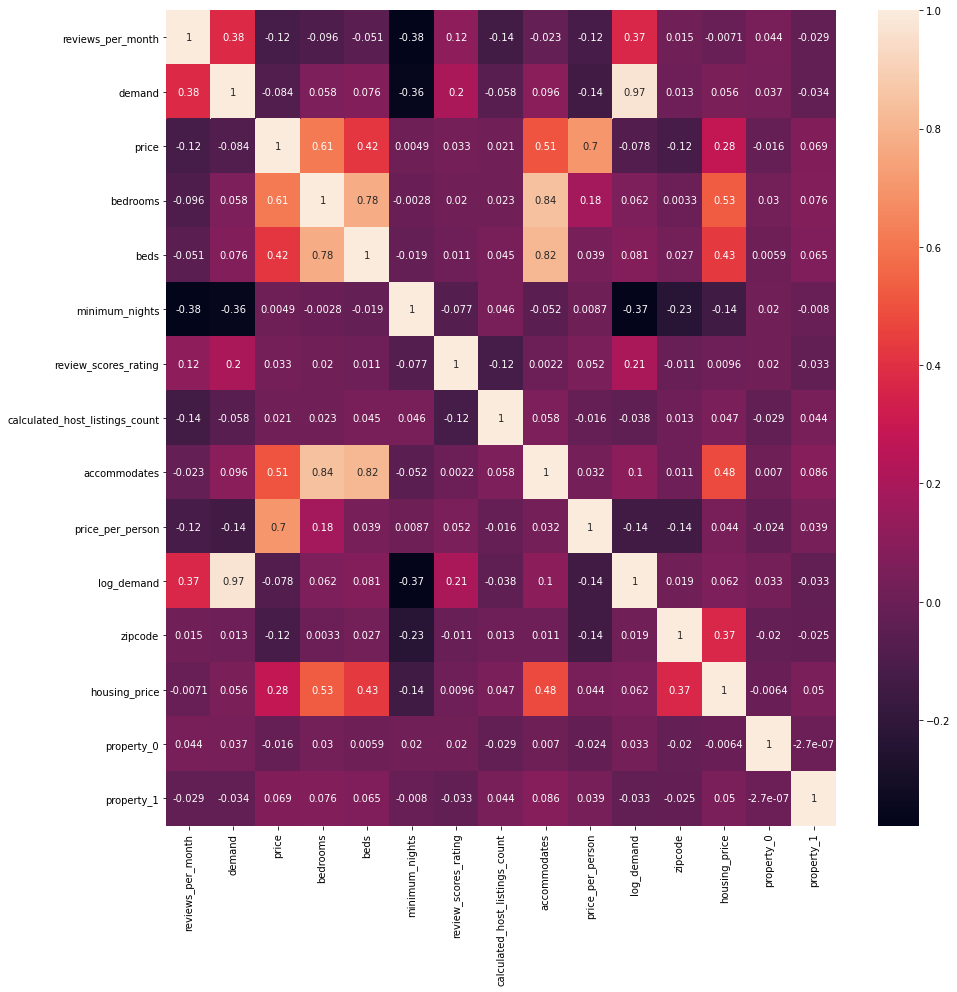

In [50]:
matrix = df.iloc[:,1:20].corr(method = 'pearson')
plt.figure(figsize=(15,15))
sns.heatmap(matrix, annot=True)
plt.show()

XGBoost Regression

In [324]:
import xgboost as xgb
from random import uniform
from random import randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [328]:
df.columns

Index(['id', 'reviews_per_month', 'demand', 'price', 'neighbourhood_cleansed',
       'bedrooms', 'beds', 'room_type', 'minimum_nights', 'listing_url',
       'host_since', 'review_scores_rating', 'calculated_host_listings_count',
       'accommodates', 'price_per_person', 'log_demand', 'zipcode',
       'housing_price', 'property_0', 'property_1', 'property_2', 'property_3',
       'property_4', 'property_5', 'property_6', 'property_7', 'property_8',
       'property_9', 'amenity_0', 'amenity_1', 'amenity_2', 'amenity_3',
       'amenity_4', 'amenity_5', 'amenity_6', 'amenity_7', 'amenity_8',
       'amenity_9', 'amenity_10', 'amenity_11', 'amenity_12', 'amenity_13',
       'amenity_14', 'amenity_15', 'amenity_16', 'amenity_17', 'amenity_18',
       'amenity_19'],
      dtype='object')

In [325]:
df = df[df['demand'] > 0]

In [336]:
model_df = df.drop(["id", "listing_url", "price", "neighbourhood_cleansed", "log_demand", "demand", "zipcode", "host_since"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(model_df, df['demand'], test_size=0.1, random_state=42)

In [337]:
# model_df.to_csv("cleaned_data.csv")

In [338]:
cat_cols = X_train.columns[X_train.dtypes == 'object']
num_cols = X_train.columns[(X_train.dtypes == 'float64') | (X_train.dtypes == 'int64')]

In [339]:
enc_ohe = OneHotEncoder()
enc_ohe.fit(X_train[cat_cols])
def OneHotEncoding(df, enc, categories):  
    transformed = pd.DataFrame(enc.transform(df[categories]).toarray(), columns=enc.get_feature_names(categories))
    return pd.concat([df.reset_index(drop=True), transformed], axis=1).drop(categories, axis=1)
X_train = OneHotEncoding(X_train, enc_ohe, cat_cols)
X_test = OneHotEncoding(X_test, enc_ohe, cat_cols)

In [340]:
X_train

,reviews_per_month,bedrooms,beds,minimum_nights,review_scores_rating,calculated_host_listings_count,accommodates,price_per_person,housing_price,property_0,...,amenity_14,amenity_15,amenity_16,amenity_17,amenity_18,amenity_19,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,0.12,3.0,4.0,2,100.0,1,7,46.428571,272213.0,-0.497102,...,0.039228,0.210970,-0.002885,-0.033914,-0.130298,0.070016,1.0,0.0,0.0,0.0
1,0.28,3.0,4.0,2,100.0,10,10,124.075000,177403.0,2.099247,...,0.062032,-0.093521,0.159297,-0.067723,0.081325,-0.253102,1.0,0.0,0.0,0.0
2,0.37,2.0,3.0,2,100.0,45,5,85.500000,173679.0,-0.144650,...,-0.073448,0.057968,0.306438,0.063077,0.057467,-0.021505,1.0,0.0,0.0,0.0
3,0.40,1.0,1.0,30,80.0,14,1,30.500000,99555.0,0.252275,...,0.273410,0.058696,0.265779,-0.038430,-0.361868,-0.032871,0.0,0.0,1.0,0.0
4,1.15,1.0,2.0,3,99.0,1,2,72.625000,179654.0,0.147382,...,-0.031832,-0.028227,-0.159978,0.071093,0.055436,0.073222,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3909,1.00,4.0,5.0,3,100.0,119,8,72.187500,308348.0,-0.497102,...,0.126747,0.163044,0.071171,0.162656,0.074581,-0.167980,1.0,0.0,0.0,0.0
3910,0.03,1.0,1.0,30,80.0,1,2,60.000000,63570.0,0.379986,...,-0.331161,0.104192,-0.107778,0.055833,0.253992,0.170858,0.0,0.0,1.0,0.0
3911,0.24,3.0,3.0,29,86.0,8,8,21.250000,218516.0,0.403564,...,0.260605,0.302044,-0.256651,-0.046598,-0.180593,0.029684,1.0,0.0,0.0,0.0
3912,1.36,1.0,1.0,1,100.0,1,3,47.583333,69405.0,1.478725,...,-0.078542,0.038089,-0.065674,-0.182516,-0.024054,-0.107388,0.0,0.0,1.0,0.0


In [348]:
params = {'learning_rate': np.arange(0.001, 0.1, (0.1-0.001)/5), # default 0.1 
          'max_depth': np.arange(2, 6, 1), # default 3
          'n_estimators': np.arange(100, 250, 50)}
xgb_model = xgb.XGBRegressor(random_state=42)

In [349]:
xgb_search = GridSearchCV(xgb_model, params, cv=5)

In [350]:
%time xgb_search.fit(X_train, y_train, verbose = 1)

Wall time: 1min 35s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parame

In [351]:
xgb_search.best_params_

{'learning_rate': 0.06040000000000001, 'max_depth': 5, 'n_estimators': 200}

In [352]:
fi_dict = dict()
for x, y in zip(xgb_search.best_estimator_.get_booster().feature_names, xgb_search.best_estimator_.feature_importances_):
    fi_dict[x] = y

In [353]:
fi_list = [[x, y] for x, y in zip(xgb_search.best_estimator_.get_booster().feature_names, xgb_search.best_estimator_.feature_importances_)]

In [354]:
fi_list.sort(key = lambda x: -x[1])

In [355]:
fi_list[:20]

[['room_type_Entire home/apt', 0.17379946],
 ['reviews_per_month', 0.0897441],
 ['minimum_nights', 0.07770469],
 ['calculated_host_listings_count', 0.040124964],
 ['room_type_Private room', 0.029837422],
 ['price_per_person', 0.027334098],
 ['amenity_0', 0.02679753],
 ['room_type_Hotel room', 0.025243135],
 ['review_scores_rating', 0.02518497],
 ['property_7', 0.022963976],
 ['property_2', 0.022094455],
 ['property_5', 0.020618524],
 ['property_8', 0.019755615],
 ['property_6', 0.019244364],
 ['amenity_6', 0.017610068],
 ['amenity_7', 0.017007465],
 ['property_4', 0.016994478],
 ['amenity_9', 0.01675455],
 ['amenity_1', 0.016357528],
 ['property_1', 0.015953286]]

Model Evaluation

In [341]:
import shap
from sklearn.model_selection import cross_validate

In [160]:
model = xgb_search.best_estimator_.fit(X_train, y_train)

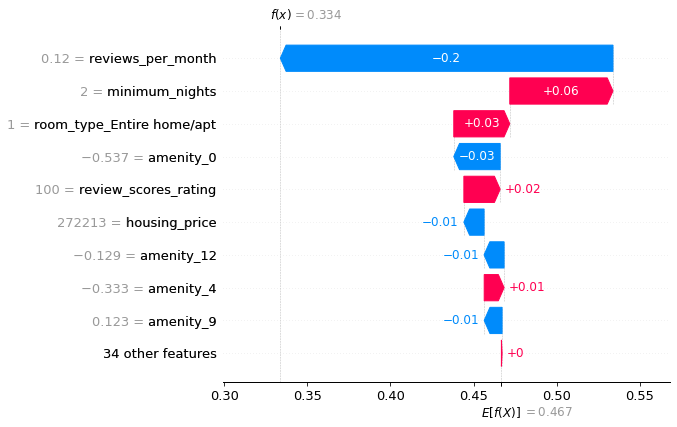

In [346]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

CV permute feature importance

In [356]:
feature_importance = {}
for columns in X_train.columns:
    old_column = X_train[columns].copy()
    X_train[columns] = np.random.permutation(X_train[columns])
    model = xgb_search.best_estimator_
    cv_results = cross_validate(model, X_train, y_train, cv=5)
    feature_importance[columns] = np.mean(cv_results['test_score'])
    X_train[columns] = old_column
    

In [357]:
feature_importance # The smaller the better

{'reviews_per_month': 0.4132407709739224,
 'bedrooms': 0.44682248300357685,
 'beds': 0.443834822698885,
 'minimum_nights': 0.3838393008421804,
 'review_scores_rating': 0.42895512928959956,
 'calculated_host_listings_count': 0.4211829459399966,
 'accommodates': 0.4385624230290164,
 'price_per_person': 0.4109085339403299,
 'housing_price': 0.4424336901336579,
 'property_0': 0.4452116824001271,
 'property_1': 0.44331576605094086,
 'property_2': 0.44357179045661865,
 'property_3': 0.44089250597085405,
 'property_4': 0.44255012865208254,
 'property_5': 0.4447206080217939,
 'property_6': 0.444783818137788,
 'property_7': 0.4460897067729125,
 'property_8': 0.44338784702202727,
 'property_9': 0.4402105880584942,
 'amenity_0': 0.4406666395064531,
 'amenity_1': 0.4427738184439409,
 'amenity_2': 0.4438535654227557,
 'amenity_3': 0.4424879598099585,
 'amenity_4': 0.4390451760142845,
 'amenity_5': 0.4417234063626564,
 'amenity_6': 0.4440636409792528,
 'amenity_7': 0.4425662213306958,
 'amenity_8': 

StandardScaler

In [359]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train.iloc[:,:-4])

In [360]:
transformed = pd.DataFrame(scaler.transform(X_train.iloc[:,:-4]), columns=X_train.columns[:-4])
X_train = pd.concat([transformed, X_train.iloc[:,-4:]], axis=1)

In [361]:
transformed = pd.DataFrame(scaler.transform(X_test.iloc[:,:-4]), columns=X_test.columns[:-4])
X_test = pd.concat([transformed, X_test.iloc[:,-4:]], axis=1)

Ridge Regression

In [362]:
from sklearn.linear_model import Ridge

In [363]:
ridge = Ridge()

In [364]:
params = {'alpha': np.arange(0.1, 2, 0.5)}

In [365]:
ridge_search = GridSearchCV(ridge, params, cv=5)

In [372]:
ridge_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([0.1, 0.6, 1.1, 1.6])})

In [394]:
ft = [[x,y] for x, y in zip(list(X_train.columns),ridge_search.best_estimator_.coef_)]

In [403]:
ft.sort(key = lambda x: -np.abs(x[1]))

In [404]:
ft

[['room_type_Entire home/apt', 0.1400336787875126],
 ['room_type_Hotel room', -0.10616073489878881],
 ['minimum_nights', -0.05869932047261637],
 ['reviews_per_month', 0.04379507626585467],
 ['price_per_person', -0.039966149478863],
 ['room_type_Shared room', -0.03494530433146278],
 ['accommodates', -0.033816682188789846],
 ['review_scores_rating', 0.030444164080935247],
 ['amenity_6', -0.026893124223337526],
 ['amenity_0', 0.0259691216056607],
 ['amenity_3', -0.0173651165007895],
 ['amenity_9', -0.01626772560456057],
 ['beds', 0.014715299570209582],
 ['amenity_2', -0.013025994329601834],
 ['amenity_11', 0.011069891641414116],
 ['amenity_19', 0.009919252682342866],
 ['amenity_8', -0.00940536518400839],
 ['property_3', -0.008299089292078479],
 ['bedrooms', 0.0077096146881725815],
 ['amenity_12', 0.007595102854197627],
 ['property_5', 0.006985804583743535],
 ['property_6', 0.006079151909344674],
 ['property_4', 0.005757362631243319],
 ['amenity_15', -0.004977128297942705],
 ['property_1',